In [551]:
from syntax_sugar import END, pipe
from syntax_sugar import process_syntax as p
from syntax_sugar import thread_syntax as t
NTHR = 16
import os
from os.path import join

In [482]:
from scipy.integrate import quad

import TMQGP as tm
from numpy import *

import QuarkTM
from QuarkTM import Channel, ChannelGroup, ChannelL, Particle

import matplotlib
matplotlib.style.use('publication23')

mQ = 0.6


qrange = linspace(0, 5, 51)
erange = linspace(-5, 5, 201)
eps = 10e-2
# pt = QuarkTM.Particle(mQ, qrange, erange, eps=5e-2)

G = 4
L = 0.5
screen = 0
G1 = 5/3

# ch = QuarkTM.Channel(pt, pt, T, G=8, screen=0, ds=4, da=1, Fa=1)

import tqdm

from scipy.optimize import minimize

params = {'G' : G, 'L' : L, 'screen' : screen}
params1 = {'G' : G1, 'L' : L, 'screen' : screen}
pss = [params, params1]
mu = 0
lmax = 0

In [483]:
T = 0.2

In [484]:
import warnings
warnings.filterwarnings('ignore')

In [485]:
def f(x, T):
    return 1/(exp(x/T) + 1)

Start of iterations

In [565]:
quark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)
aquark_run = Particle(mQ, qrange, erange, eps=eps, mu=mu)

In [566]:
lmax = 0

In [567]:
imss = array([array([-eps for q in qrange])]*2).transpose()
ress = array([array([0. for q in qrange])]*2).transpose()

In [568]:
eArr = array([erange for q in qrange]).transpose()

In [569]:
omKs = array([sqrt(mQ**2 + qrange**2)]*2).transpose()

In [570]:
mu = 0.*T

In [571]:
subtr = 0

In [629]:
# if len(ims) == 0 or len(res) == 0:
channels_QQ = QuarkTM.ChannelGroup(mu0=False)
channels_QA = QuarkTM.ChannelGroup(mu0=False)
channels_AA = QuarkTM.ChannelGroup(mu0=False)
channels_AQ = QuarkTM.ChannelGroup(mu0=False)

# ImS_K_Arr = array([ims for e in er|ange])
# ReS_K_Arr = array([res for e in erange])

ImS_K_Arrs = [array([ims for e in erange]) for ims in imss.transpose()]
ReS_K_Arrs = [array([res for e in erange]) for res in ress.transpose()]


omArrs = [array([omk for e in erange]) for omk in omKs.transpose()]

G2_QQ = (1 - 2*f(omArrs[0], T)) / (eArr - 2*omArrs[0] - 1j*2*ImS_K_Arrs[0] + 2*mu)
G2_QA = (1 - f(omArrs[0], T) - f(omArrs[1], T)) / (eArr - omArrs[0] - omArrs[1] - 1j*(ImS_K_Arrs[0] + ImS_K_Arrs[1]))
G2_AA = (1 - 2*f(omArrs[1], T)) / (eArr - 2*omArrs[1] - 1j*2*ImS_K_Arrs[1] - 2*mu)


channels_QQ.addChannel(
    QuarkTM.ChannelL('qq3', lmax, quark_run, quark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_QQ)
)

channels_QA.addChannel(
    QuarkTM.ChannelL('qa1', lmax, quark_run, aquark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
)

channels_AA.addChannel(
    QuarkTM.ChannelL('aa3', lmax, aquark_run, aquark_run, T, pss, ds=4, da=3, Fa=1/2, mu=mu, G2=G2_AA)
)

channels_AQ.addChannel(
    QuarkTM.ChannelL('aq1', lmax, aquark_run, quark_run, T, pss, ds=4, da=1, Fa=1, mu=mu, G2=G2_QA)
)

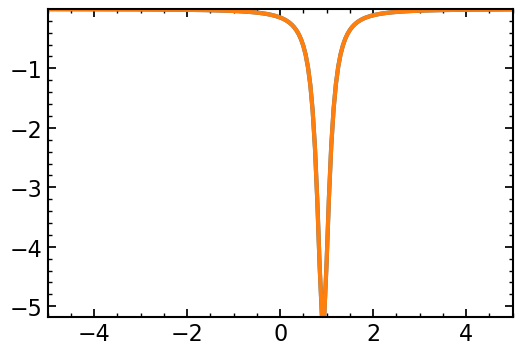

In [630]:
plt.plot(erange, imag(G2_QQ)[:, 0])
plt.plot(erange, imag(G2_AA)[:, 0])

In [631]:
chs_Q = [channels_QQ, channels_QA]
chs_A = [channels_AQ, channels_AA]

Gs_Q = [G2_QQ, G2_QA]
Gs_A = [G2_QA, G2_AA]

In [632]:
omKs_old = omKs.copy()

omKs = []
ress = []
imss = []

for k in tqdm.notebook.tqdm(qrange):
    xs = []
    res = []
    ims = []
    for i, chs, Gs, lbl in zip(range(2), [chs_Q, chs_A], [Gs_Q, Gs_A], ['Q', 'A']):
        delta = 1
        # print(lbl)
        x = sqrt(mQ**2 + k**2) # initial guess

        while delta > 1e-3:
            re = 0
            im = 0
            for j, ch in enumerate(chs):
                TM = ch.get_T()
                TM[erange < 0] = real(TM[erange < 0])
                if subtr:
                    TM -= (TM[0, :] + TM[1, :])/2
                iReTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(real(TM)))
                iImTM = tm.Interpolator2D(qrange, erange, ascontiguousarray(imag(TM)))
                iEps_i = tm.Interpolator(qrange, ascontiguousarray(omArrs[i][0, :]), 'cubic')
                iEps_j = tm.Interpolator(qrange, ascontiguousarray(omArrs[j][0, :]), 'cubic')
                _re = tm.SigmaQP(float(x), k, T, iReTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                _im = tm.SigmaQP(float(x), k, T, iImTM, quark_run.R, iEps_i, iEps_j, 0, 0)
                re += _re
                im += _im
            x0 = x
            x = sqrt(mQ**2 + k**2) + re
            delta = abs(x - x0)
            # print('k = ', k, 'delta = ', delta)
        xs += [x]
        ims += [im]
        res += [re]
    omKs += [xs]
    ress += [res]
    imss += [ims]

  0%|          | 0/51 [00:00<?, ?it/s]

In [633]:
omKs = array(omKs)
omKs_old = array(omKs_old)
imss = array(imss)
ress = array(ress)

In [634]:
np.max(abs(omKs_old - omKs))

0.0009620671107264944

(0.0, 2.5)

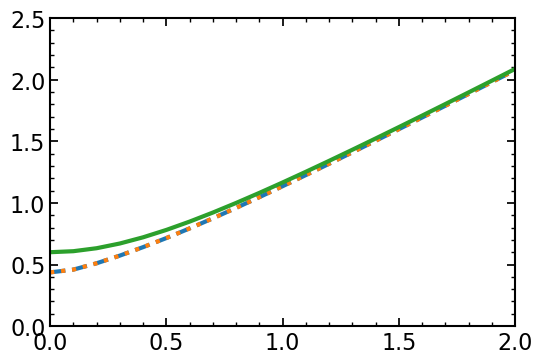

In [592]:
plt.plot(qrange, omKs[:, 0], ls='--')
plt.plot(qrange, omKs[:, 1], ls=':')
plt.plot(qrange, sqrt(mQ**2 + qrange**2))



plt.xlim(0, 2)
plt.ylim(0, 2.5)

Text(0.5, 0, 'k [GeV]')

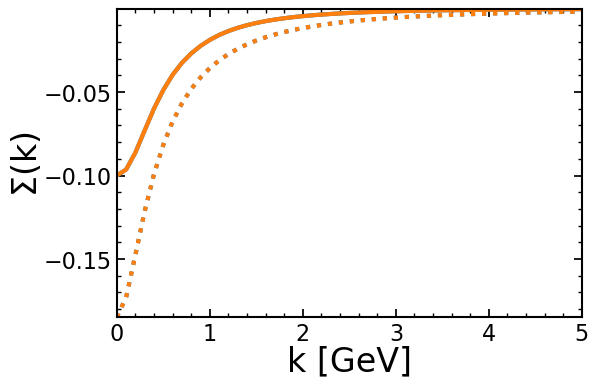

In [585]:
lQ, = plt.plot(qrange, imss[:, 0], ls='-')
plt.plot(qrange, ress[:, 0], ls=':', c=lQ.get_c())

lA, = plt.plot(qrange, imss[:, 1], ls='-')
plt.plot(qrange, ress[:, 1], ls=':', c=lA.get_c())



# plt.plot(qrange, sqrt(mQ**2 + qrange**2))

# plt.xlim(0, 2)
# plt.ylim(0, 2.5)

plt.ylabel(r'$\Sigma(k)$')
plt.xlabel('k [GeV]')

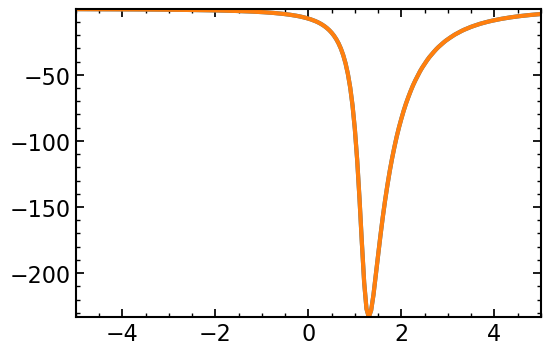

In [547]:
plt.plot(erange, imag(channels_QQ.get_T())[:, 0])
plt.plot(erange, imag(channels_AA.get_T())[:, 0])

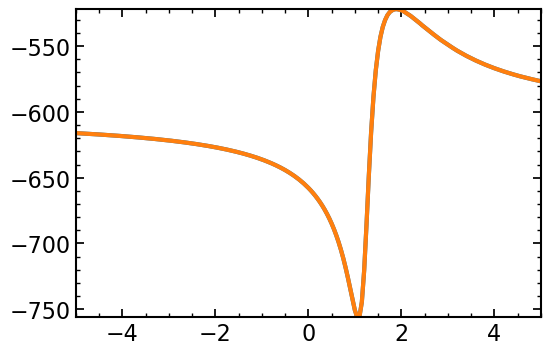

In [548]:
plt.plot(erange, real(channels_QQ.get_T())[:, 0])
plt.plot(erange, real(channels_AA.get_T())[:, 0])

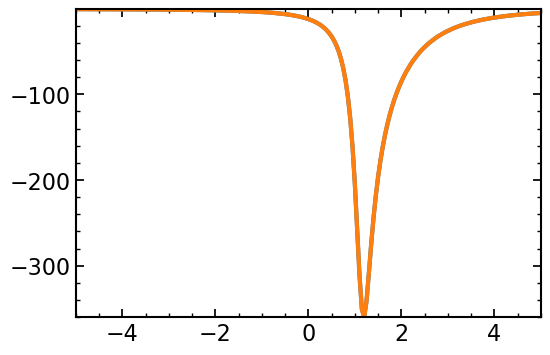

In [549]:
plt.plot(erange, imag(channels_QA.get_T())[:, 0])
plt.plot(erange, imag(channels_AQ.get_T())[:, 0])